# Learning a nonlinear stencil for Burgers's equation

In [2]:
import sys
if False: # On colab
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else: # Local
    root = './'
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda:3')
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Connected to a GPU


In [41]:
import importlib
import util
importlib.reload(util)
from util import *

This training loop only does simple MSE training on one step. 

In [34]:
loss = torch.nn.MSELoss()
def train_it(dataset, model,
             OPTIM=torch.optim.Adam, learning_rate = 1e-1, batch_size=20,
             Npast=1, Nfuture=1):
    optimizer = OPTIM(model.parameters(), lr=learning_rate)
    Nepoch = 4000

    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Nbatch = batch_size #Ntotal//10
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,2))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset)
        y_pred = model(xx)+xx
        L = loss(y_pred,yy)
        h = y_pred
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        if e%Nprint == Nprint-1:
            print(e,L.item())
        if e%Nsave == Nsave-1:
            xxt,yyt = test_batch(dataset)
            yt_pred = model(xxt)+xxt
            test_err = loss(yyt,yt_pred)
            losses[e//Nsave,0] = L.item()
            losses[e//Nsave,1] = test_err.item()
    return losses

Load the dataset filled with anayltical soltions. The trajectories are linear fronts, rarifaction fans, shock fronts, and one parabola. The parabola is saved for validation.

In [7]:
dataname = "burgers"
data = np.load(root+f"data/{dataname}.npz")
dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
Ntraj,Nt,Nx = dataset.shape

## Let's do a hyperparameter search on the deep stencil:

Here is the poor-man's database: only execute one of these:

In [ ]:
with open(root+f"/models_{dataname}.pkl","rb") as f:
    deepstencil_stash = torch.load(f)

In [38]:
deepstencil_stash = {}

In [ ]:
for act in ["CELU","Sigmoid"]:#"LeakyReLU","ReLU",Tanh
    for depth in [3,]:
        for channels in [5,]:
            key = (act,depth,channels)
            try:
                entry = deepstencil_stash[key]
                print("Resuming training of ",key)
            except KeyError:
                entry = { 'model'   : LeakyDeepStencil(Nx,3,channels,depth,act).to(device),
                        'results' : np.empty((0,2)) }
                print("Training new ",key)
            model = entry['model']
            results = entry['results']
            tr_res = train_it(dataset,model,learning_rate=1.0e-3, batch_size=50)
            results = np.append(results, tr_res, axis=0)
            deepstencil_stash[key] = {'model':model,'results':results}
with open(root+f"/models_{dataname}.pkl","wb") as f:
    torch.save(deepstencil_stash,f)

Resuming training of  ('CELU', 3, 5)
11639 0.000569004740100354


In [ ]:
with open(root+f"/models_{dataname}.pkl","wb") as f:
    torch.save(deepstencil_stash,f)

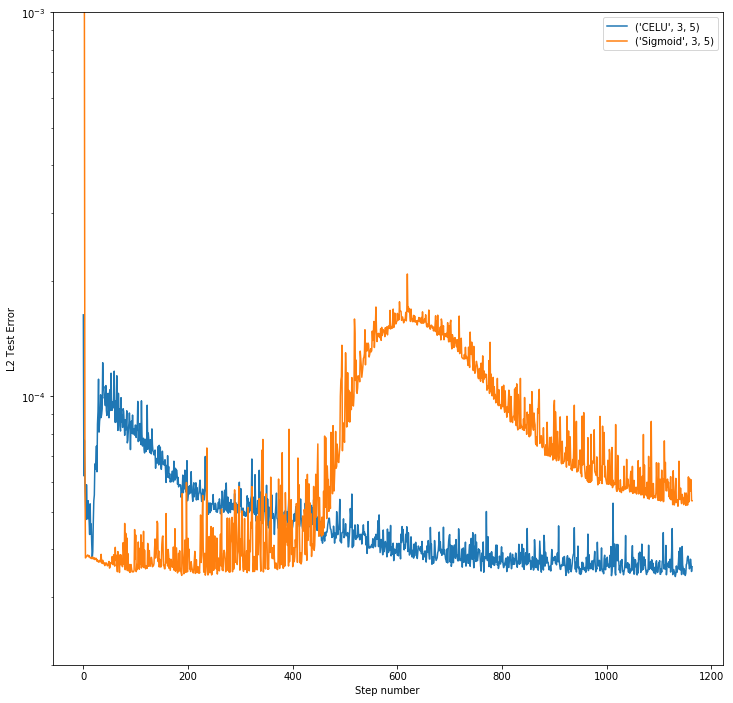

In [43]:
plt.figure(figsize=(12,12))
alpha_channel=1
for N,S in deepstencil_stash.items():
    #plt.semilogy(S['results'][:,1],label=f"{N}, L2")
    plt.semilogy(S['results'][:,1],label=N,alpha=alpha_channel)
    #alpha_channel = 0.25
    #label = None
plt.legend()
plt.ylim((2e-5,1e-3))
plt.xlabel('Step number')
plt.ylabel('L2 Test Error')
plt.savefig(root+'/paper/burgers_loss.png',dpi=300)
plt.show()

Trajectory  0


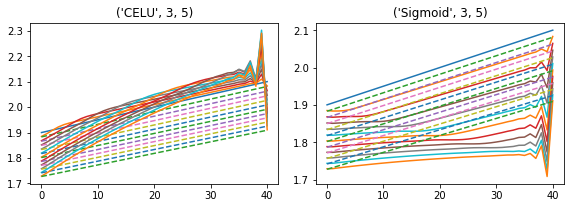

Trajectory  1


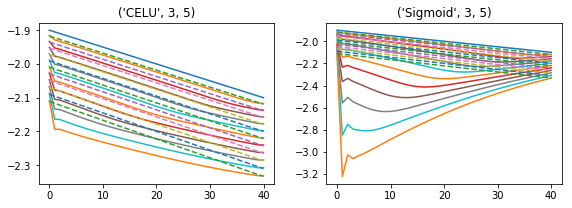

Trajectory  2


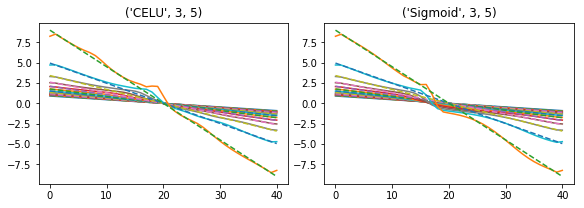

Trajectory  3


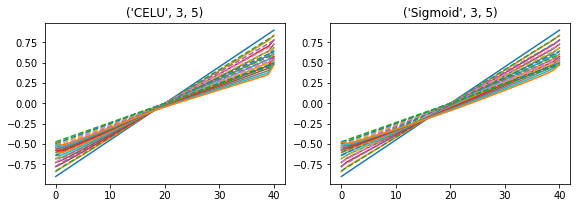

Trajectory  4


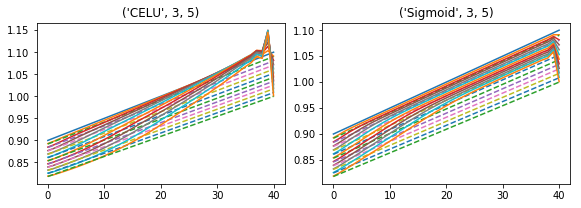

Trajectory  5


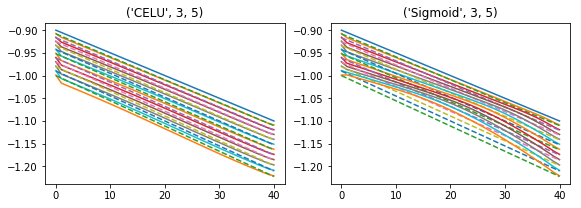

Trajectory  6


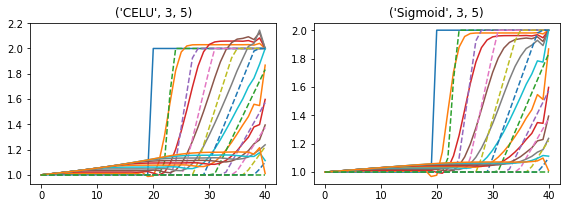

Trajectory  7


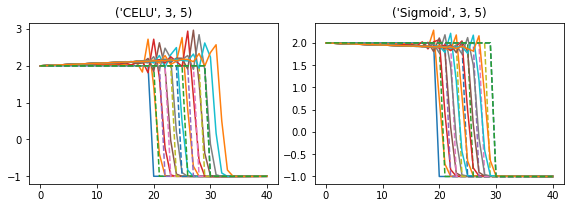

Trajectory  8


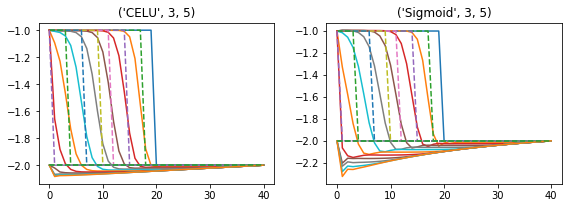

Trajectory  9


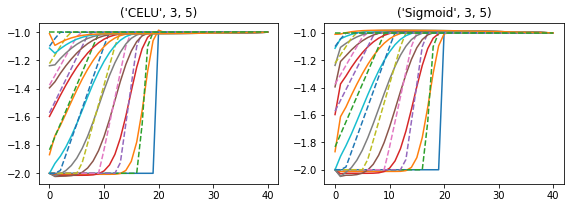

Trajectory  10


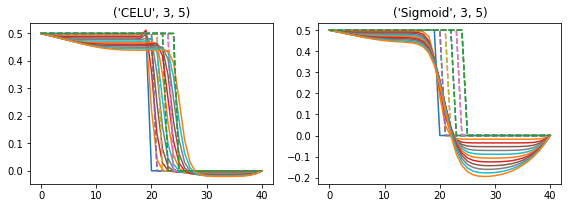

Trajectory  11


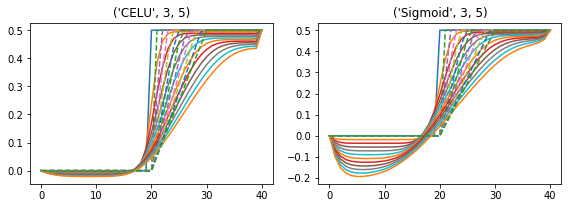

Trajectory  12


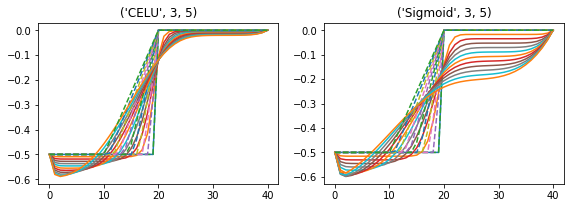

Trajectory  13


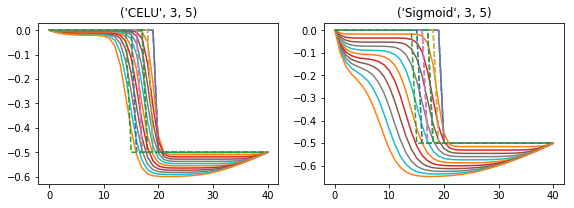

Trajectory  14


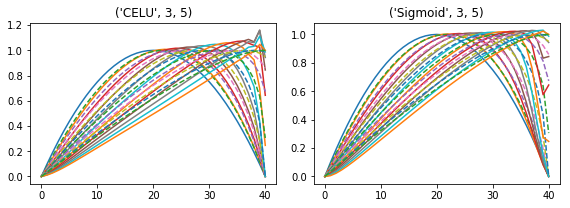

In [44]:
for traj in range(Ntraj): #range(Ntraj-Ntraj_val,Ntraj):
    print("Trajectory ",traj)
    plt.figure(figsize=(12,8))
    err = {}
    for i,(N,S) in enumerate(deepstencil_stash.items()):
        plt.subplot(3,3,i+1)
        err[N] = do_a_path(S['model'],dataset,traj,0)
        plt.title(N)

    #for N,e in err.items():
    #    plt.plot(e,label=N)
    #plt.legend()
    plt.tight_layout()
    plt.show()

Because we had a compact stencil, the model does not depend on the original size of the mesh. It can be applied to a much better problem that looks like nothing inthe training set:

In [ ]:
xs = np.linspace(-10,10,2000)
u0 = -np.sin(xs)
for i,(N,S) in enumerate(deepstencil_stash.items()):
    plt.figure(figsize=(18,6))
    plt.ylim((-2,3))
    plt.xlim((0,2000))
    do_an_unknown_path(S['model'], torch.tensor(u0,dtype=torch.float32).to(device), 1000)
    plt.title(N)
    plt.show()

# Trying multiple architecture types

In [ ]:
stash = {}

In [29]:
models = {#"PureStencil":PureStencil,
         #"PureLinear":PureLinear,
          "DeepStencil":DeepStencil,
          "LeakyDeepStencil":LeakyDeepStencil,
         "LeakyFCMLP":LeakyFCMLP,
          "FCMLP":FCMLP
         }
for name, cls in models.items():
    try:
        model =  stash[name]['model']
        disc =   stash[name]['disc']
        results =stash[name]['loss'] 
        print("Resuming training of ",name)
    except KeyError:
        model = cls(Nx).to(device)
        disc = ConditionalDiscriminatorConv(Nx,1).to(device)
        results = np.empty((0,2))
        print("Training new ",name)
    tr_res = train_it(dataset,model,learning_rate=1.0e-2, batch_size=50)
    results = np.append(results, tr_res, axis=0)
    stash[name] = {'model':model,
                    'disc':disc,
                    'loss':results}
with open(root+f"/data_{dataname}.pkl","wb") as f:
    torch.save(stash,f)

NameError: ignored

In [12]:
for N,S in deepstencil_stash.items():
    plt.semilogy(S['loss'][:,0],label=N)
    plt.semilogy(S['loss'][:,1],label=f"test {N}")
    plt.legend()
    plt.show()

KeyError: ignored

DeepStencil


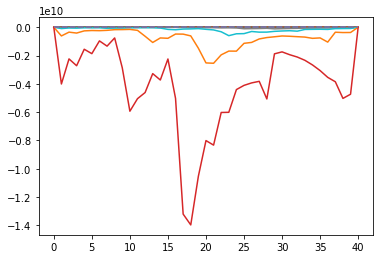

LeakyDeepStencil


/content/drive/My Drive/Colab Notebooks/burgers/util.py:224: RuntimeWarning: overflow encountered in true_divide
  errors[i] = np.linalg.norm((ucpu - dcpu)/(np.abs(dcpu)+1.0e-5))


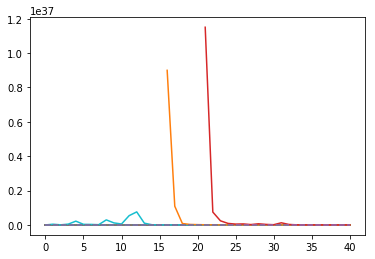

LeakyFCMLP


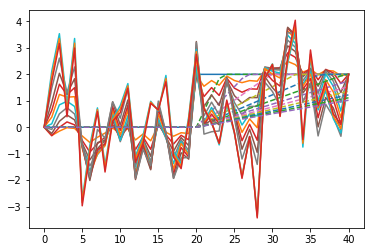

FCMLP


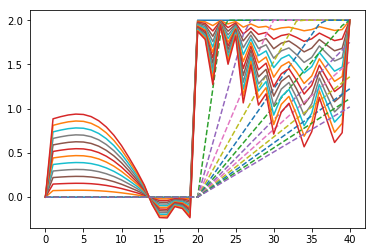

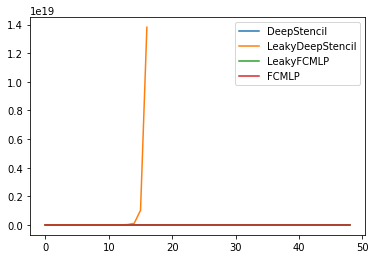

DeepStencil


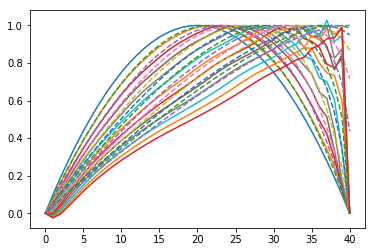

LeakyDeepStencil


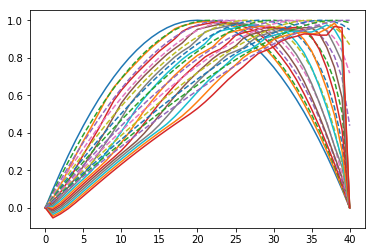

LeakyFCMLP


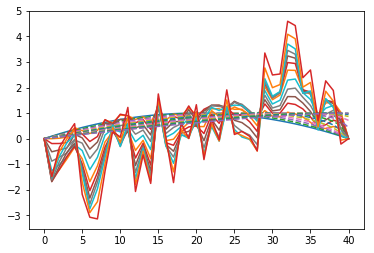

FCMLP


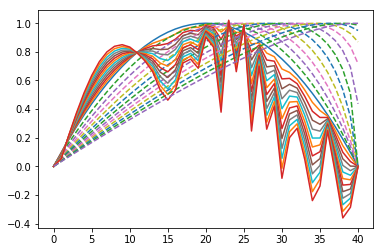

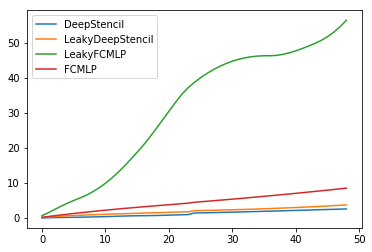

In [13]:
for i in range(Ntraj-Ntraj_val,Ntraj):
    err = {}
    for N,S in stash.items():
        print(N)
        err[N] = do_a_path(S['model'],dataset,i,0)
    for N,e in err.items():
        plt.plot(e,label=N)
    plt.legend()
    plt.show()